### Exploring relationships between stringency of lockdowns and music listening habits

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re 
import numpy as np
from sklearn.linear_model import LinearRegression
from pystout import pystout
import statsmodels.api as sm

In [2]:
df = pd.read_csv("data/full_dataset_sentiment_analysis.csv")

In [3]:
df['year'] = df['title'].str.extract('(\d{4})', expand=True)
df['country'] = df['title'].str.extract(r'Top Songs of (\d\d\d\d): (.*)')[1]

In [4]:
df = df.drop(columns=["enumerated_list", "lyrics_not_found"])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952 entries, 0 to 951
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.3  952 non-null    int64  
 1   Unnamed: 0.2  952 non-null    int64  
 2   Unnamed: 0.1  952 non-null    int64  
 3   Unnamed: 0    952 non-null    int64  
 4   songs         952 non-null    object 
 5   artist        952 non-null    object 
 6   title         952 non-null    object 
 7   lyrics        952 non-null    object 
 8   sentiment     952 non-null    object 
 9   neg           952 non-null    float64
 10  neu           952 non-null    float64
 11  pos           952 non-null    float64
 12  compound      952 non-null    float64
 13  year          952 non-null    object 
 14  country       952 non-null    object 
dtypes: float64(4), int64(4), object(7)
memory usage: 111.7+ KB


In [6]:
df_grouped = (
    df[['neg', 'pos', 'neu', 'year', 'country']].groupby(['country', 'year'])
    .agg(['mean'])
)

In [7]:
df_grouped = df_grouped.droplevel(axis=1, level=1).reset_index()

In [8]:
df_grouped["ratio"]=df_grouped["neg"]/df_grouped["pos"]
df_grouped

,country,year,neg,pos,neu,ratio
0,Australia,2019,0.109294,0.169353,0.721341,0.645363
1,Australia,2020,0.116071,0.138400,0.745541,0.838660
2,Australia,2021,0.118078,0.155805,0.726091,0.757856
3,Australia,2022,0.107183,0.150854,0.741902,0.710509
4,New Zealand,2019,0.117184,0.169539,0.713276,0.691191
5,New Zealand,2020,0.114917,0.142167,0.742917,0.808324
6,New Zealand,2021,0.111316,0.132595,0.756051,0.839523
7,New Zealand,2022,0.110341,0.145565,0.744129,0.758021
8,USA,2019,0.155149,0.125541,0.719270,1.235845
9,USA,2020,0.155580,0.119942,0.724493,1.297124


In [9]:
covid = pd.read_csv("data/covid policies/stay-at-home-covid.csv")

In [10]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202847 entries, 0 to 202846
Data columns (total 4 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Entity                  202847 non-null  object
 1   Code                    202847 non-null  object
 2   Day                     202847 non-null  object
 3   stay_home_requirements  202847 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 6.2+ MB


In [11]:
covid["stay_home_requirements"].value_counts()

0    111364
2     50283
1     36230
3      4970
Name: stay_home_requirements, dtype: int64

In [12]:
covid["year"] = pd.DatetimeIndex(covid["Day"]).year
covid_filtered = covid[covid["year"]<=2021]


In [13]:
covid_by_year_world = (
    covid_filtered[["stay_home_requirements", "Entity"]].groupby(["Entity"])
    .agg(['mean'])
)

#covid_by_year_world = covid_by_year_world.droplevel(axis=1, level=1).reset_index()

covid_by_year_world.to_csv("data/covid policies/covid_world_means.csv")

Countries are grouped into four categories:

+ 0 - No measures
+ 1 - Recommended not to leave the house
+ 2 - Required to not leave the house with exceptions for daily exercise, grocery shopping, and ‘essential’ trips
+ 3 - Required to not leave the house with minimal exceptions (e.g. allowed to leave only once every few days, or only one person can leave at a time, etc.)

In [14]:
covid = covid[(covid["Code"]=="AUS") | (covid["Code"]=="USA") | (covid["Code"]=="NZL")] 
covid["Entity"].value_counts()

Australia        1096
New Zealand      1096
United States    1096
Name: Entity, dtype: int64

In [15]:
covid["year"] = pd.DatetimeIndex(covid["Day"]).year
covid



,Entity,Code,Day,stay_home_requirements,year
7672,Australia,AUS,2020-01-01,0,2020
7673,Australia,AUS,2020-01-02,0,2020
7674,Australia,AUS,2020-01-03,0,2020
7675,Australia,AUS,2020-01-04,0,2020
7676,Australia,AUS,2020-01-05,0,2020
...,...,...,...,...,...
192978,United States,USA,2022-12-27,1,2022
192979,United States,USA,2022-12-28,1,2022
192980,United States,USA,2022-12-29,1,2022
192981,United States,USA,2022-12-30,1,2022


In [19]:
covid_by_year = (
    covid[["stay_home_requirements", "Entity", "year"]].groupby(['Entity', 'year'])
    .agg(['mean', 'std'])
)

covid_by_year = covid_by_year.droplevel(axis=1, level=1).reset_index()

covid_by_year

,Entity,year,stay_home_requirements,stay_home_requirements
0,Australia,2020,1.183060,0.910720
1,Australia,2021,1.030137,1.000918
2,Australia,2022,0.120548,0.476641
3,New Zealand,2020,0.393443,0.792679
4,New Zealand,2021,0.657534,0.940820
5,New Zealand,2022,0.000000,0.000000
6,United States,2020,1.595628,0.804360
7,United States,2021,1.169863,0.376028
8,United States,2022,0.657534,0.475186


In [20]:
covid_by_year["country"] = covid_by_year["Entity"]
covid_by_year= covid_by_year.drop(columns=["Entity"])

covid_by_year["country"]= covid_by_year["country"].str.replace(r'United States', 'USA')

df_grouped["year"]=df_grouped["year"].astype(np.int64)

In [21]:
covid_by_year_viz = covid_by_year[covid_by_year["year"]<=2021]


covid_by_year_viz = (
    covid_by_year_viz[["stay_home_requirements", "country"]].groupby(['country'])
    .agg(['mean', 'std'])
)

covid_by_year_viz = covid_by_year_viz.droplevel(axis=1, level=1).reset_index()
covid_by_year_viz


,country,stay_home_requirements,stay_home_requirements,stay_home_requirements,stay_home_requirements
0,Australia,1.106599,0.108133,0.955819,0.063780
1,New Zealand,0.525488,0.186741,0.866750,0.104751
2,USA,1.382746,0.301062,0.590194,0.302876


In [22]:
df_full = pd.merge(df_grouped,covid_by_year,how='left',left_on=["country", str("year")], right_on=["country", str("year")])

In [23]:
df_full = df_full.replace(np.nan, 0)
df_full

,country,year,neg,pos,neu,ratio,stay_home_requirements,stay_home_requirements
0,Australia,2019,0.109294,0.169353,0.721341,0.645363,0.000000,0.000000
1,Australia,2020,0.116071,0.138400,0.745541,0.838660,1.183060,0.910720
2,Australia,2021,0.118078,0.155805,0.726091,0.757856,1.030137,1.000918
3,Australia,2022,0.107183,0.150854,0.741902,0.710509,0.120548,0.476641
4,New Zealand,2019,0.117184,0.169539,0.713276,0.691191,0.000000,0.000000
5,New Zealand,2020,0.114917,0.142167,0.742917,0.808324,0.393443,0.792679
6,New Zealand,2021,0.111316,0.132595,0.756051,0.839523,0.657534,0.940820
7,New Zealand,2022,0.110341,0.145565,0.744129,0.758021,0.000000,0.000000
8,USA,2019,0.155149,0.125541,0.719270,1.235845,0.000000,0.000000
9,USA,2020,0.155580,0.119942,0.724493,1.297124,1.595628,0.804360


Text(0.5, 1.0, 'Ratio negative/positive sentiments')

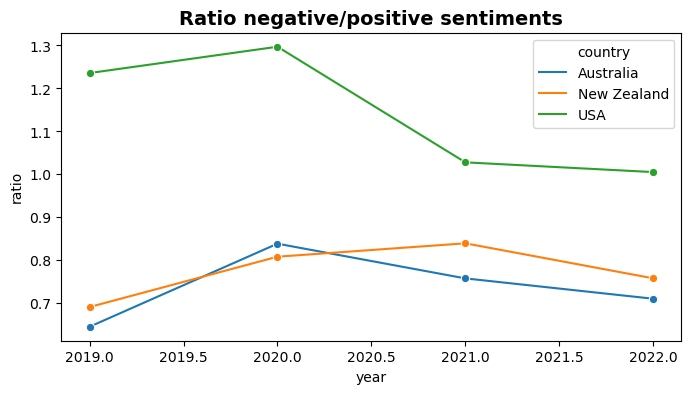

In [24]:
fig, g = plt.subplots(figsize=(8, 4))
sns.lineplot(x=df_full['year'], y=df_full['ratio'], hue=df_full["country"], marker='o')

g.set_title('Ratio negative/positive sentiments', fontweight="bold", fontsize=14) # setting title

Text(0.5, 1.0, 'Ratio negative/positive sentiments')

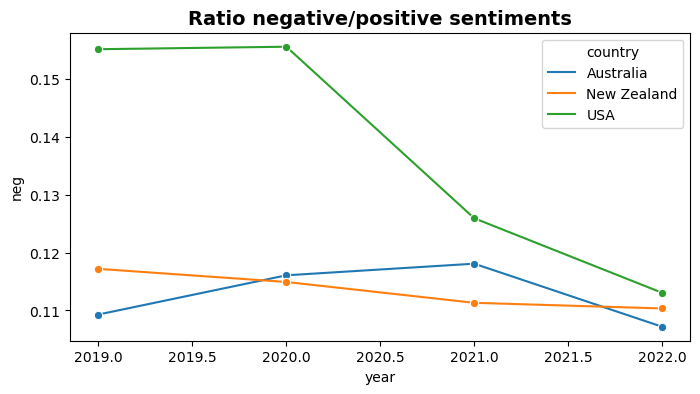

In [25]:
fig, g = plt.subplots(figsize=(8, 4))
sns.lineplot(x=df_full['year'], y=df_full['neg'], hue=df_full["country"], marker='o')

g.set_title('Ratio negative/positive sentiments', fontweight="bold", fontsize=14) # setting title

Text(0.5, 1.0, 'Ratio negative/positive sentiments')

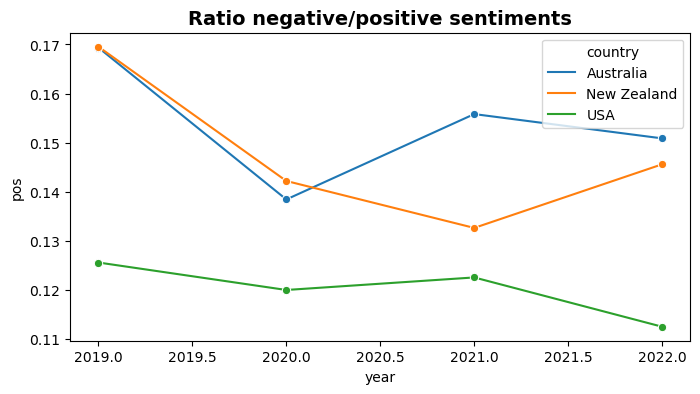

In [26]:
fig, g = plt.subplots(figsize=(8, 4))
sns.lineplot(x=df_full['year'], y=df_full['pos'], hue=df_full["country"], marker='o')

g.set_title('Ratio negative/positive sentiments', fontweight="bold", fontsize=14) # setting title

In [27]:
# Focusing on the change in sentiment

df_pivot = df_full.pivot(values="ratio", index="country", columns="year")
df_pivot

year,2019,2020,2021,2022
country,,,,
Australia,0.645363,0.838660,0.757856,0.710509
New Zealand,0.691191,0.808324,0.839523,0.758021
USA,1.235845,1.297124,1.028020,1.005314


In [28]:
df_pivot["diff_2020_2019"]=df_pivot[2020]-df_pivot[2019]
df_pivot["diff_2021_2019"]=df_pivot[2021]-df_pivot[2019]
df_pivot["diff_2022_2019"]=df_pivot[2022]-df_pivot[2019]

In [29]:
df_pivot

year,2019,2020,2021,2022,diff_2020_2019,diff_2021_2019,diff_2022_2019
country,,,,,,,
Australia,0.645363,0.838660,0.757856,0.710509,0.193297,0.112493,0.065146
New Zealand,0.691191,0.808324,0.839523,0.758021,0.117132,0.148331,0.066830
USA,1.235845,1.297124,1.028020,1.005314,0.061279,-0.207825,-0.230531
